In [1]:
# CNN(Convolutional Neural Network) - MNIST Dataset

# 딥러닝 CNN 아키텍처
# - Conv->ReLU->Pool->Dropout ->Conv->ReLU->Pool->Dropout ->FC->ReLU->Dropout ->FC
# 학습
# - StepLR : 일정 에폭마다 학습률을 감소시킨다.
# - EarlyStopping : 일정 에폭 동안 성능 향상이 없을 경우 학습을 조기 중단, 과적합 방지, 학습 시간 절약
# 시각화
# - confusion_matrix(혼돈 행렬), classification_report

In [2]:
import torch

print("PyTorch 버전:", torch.__version__)
print("CUDA 사용 가능:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU 디바이스 수:", torch.cuda.device_count())
    print("사용 중인 GPU 이름:", torch.cuda.get_device_name(0))
    print("현재 디바이스:", torch.device("cuda"))
else:
    print("CUDA를 사용할 수 없습니다. CPU로 설정됩니다.")

PyTorch 버전: 2.7.1+cu118
CUDA 사용 가능: True
GPU 디바이스 수: 1
사용 중인 GPU 이름: NVIDIA GeForce RTX 3060 Laptop GPU
현재 디바이스: cuda


In [3]:
# 1) import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [4]:
# 2) MNIST Dataset 다운로드

# transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.1307,), (0.3081,) )
])

# train
train_dataset = datasets.MNIST(root='./data/MNIST_data',
                               train=True,
                               transform=transform,
                               download=True)
# test
test_dataset = datasets.MNIST(root='./data/MNIST_data',
                               train=False,
                               transform=transform,
                               download=True)

In [5]:
# MNIST Dataset 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
# 3) MNIST Dataset 데이터 분리 - train 85% : validation 15%
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
# validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
validation_dataset_size = len(train_dataset) - train_dataset_size # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [7]:
# MNIST Dataset 데이터 분리 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [8]:
# 4) Batch, DataLoader 생성
BATCH_SIZE = 32

# train
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

# validation
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

# test
test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


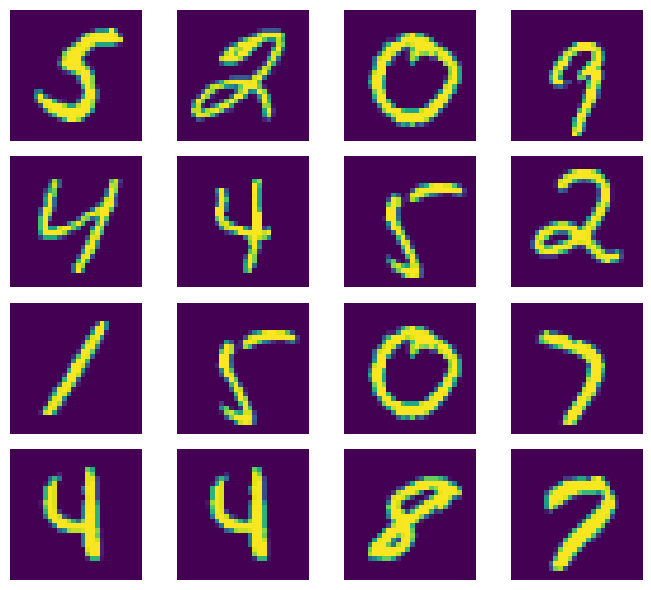

In [9]:
# 5) MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# 6) CNN Model
# 딥러닝 CNN 아키텍처
# Conv->ReLU->Pool->Dropout ->Conv->ReLU->Pool->Dropout ->FC->ReLU->Dropout ->FC

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)        
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # conv1, data shape = (H, W, C) = (28, 28, 1)
        x = self.conv1(x) # (28, 28, 1)
        x = torch.relu(x) # (28, 28, 32)
        x = self.pooling(x) # (28, 28, 32)
        x = self.dropout25(x) # (14, 14, 32)
        # conv2
        x = self.conv2(x) # (14, 14, 32)
        x = torch.relu(x) # (14, 14, 64)
        x = self.pooling(x) # (14, 14, 64)
        x = self.dropout25(x) # (7, 7, 64)
        # data shape
        # x = x.view(-1, 7 * 7 * 64) # 고정된 크기에는 맞으나 입력 크기가 변경시 오류 발생 할 수 있음
        x = x.view(x.size(0), -1) # - x.size(0)는 현재 배치 크기를 자동으로 가져오므로, 배치 사이즈가 바뀌어도 오류 없이 작동, - -1은 나머지 차원을 자동으로 계산해주기 때문에 입력 이미지 크기나 Conv 구조가 바뀌어도 대응 가능

        # Linear
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout50(x)
        
        x = self.fc2(x)

        return x

In [11]:
# 8) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience # 개선되지 않아도 기달릴 에폭 수
        self.min_delta = min_delta # 개선으로 간주할 최소 변화량
        self.best_loss = float('inf') # 가장 낮은 validation loss
        self.counter = 0 # 개선되지 않는 에폭 수
        self.early_stop = False # 중단 여부
    
    def __call__(self, val_loss):
        # 매 에폭마다 validation loss를 받아서 개선 여부를 판단한다.
        # val_loss < self.best_loss - self.min_delta 이면 개선된 것으로 간주한다.
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        # 그렇지 않으면 counter를 증가시키고, counter가 patience 이상이면 early_stop을 True로 설정해 학습 중단 신호를 보낸다.
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [12]:
# 8) model, loss, optimizer 객체 생성 및 StepLR 스케줄러 정의
#  Model 객체 생성
model = CNNModel().to(DEVICE)

# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# StepLR 스케줄러 정의
scheduler = StepLR(optimizer, step_size=5, gamma=0.5) # 5 에폭마다 학습률을 절반으로 감소

# Model 정보
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


In [13]:
# 9) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [14]:
# 10) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [15]:
# 11) Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [16]:
# 12) 모델 전체 테스트셋 추론 및 오답 시각화

# 전체 테스트셋 추론 함수
def model_all_test(dataloader, model):
    model.eval() # 추론 모드

    all_preds = []
    all_labels = []
    all_images = []

    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    total_test_batch = len(dataloader)

    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            images = images.to(DEVICE) # 입력 데이터
            labels = labels.to(DEVICE) # 정답 데이터

            outputs = model(images) # 모델 예측
            _, preds = torch.max(outputs, dim=1) # 모델 예측값 추출

            all_preds.extend(preds.cpu().numpy()) # 예측값 넘파이로 변환 후 리스트 담는다.
            all_labels.extend(labels.cpu().numpy()) # 정답값 넘파이로 변환 후 리스트 담는다.
            all_images.extend(images.cpu())

            loss = loss_function(outputs, labels)
            test_loss_sum += loss.item()
            test_total += labels.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total
        
        print('accuracy = ', test_avg_accuracy, 'loss = ', test_avg_loss)
    
    # 오답 샘플 추출
    wrong_indices = [ i for i in range(len(all_preds)) if all_preds[i] != all_labels[i] ]

    # labels map 생성 - train_dataset 에서 정답 label map을 생성
    labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }

    # Confusion Matrix 시각화 -----------------------------------------------------------------
    # Confusion Matrix 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(labels_map.values()), 
                yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

     # Classification Report ----------------------------------------------------------------
     # precision(예측한 것 중에 실제로 맞춘 비율), recall(실제 정답 중에 얼마나 맞췄는지), f1-score(precision과 recall의 조화 평균), support(각 클래스의 샘플 수)
    report = classification_report(all_labels, all_preds, target_names=list(labels_map.values()))
    print('classification report:\n', report)

    # 오답 시각화 ------------------------------------------------------------------------------
    print('\n오답 시각화:')
    plt.figure(figsize=(10, 9))
    cols, rows = 5, 4

    for i in range(1, cols * rows + 1):
        if i > len(wrong_indices):
            break
        idx = wrong_indices[i - 1]
        img = all_images[i].squeeze()
        true_label = all_labels[idx]
        pred_label = all_preds[idx]

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'T: {labels_map[true_label]}\nP: {labels_map[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
# 13) Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

# EarlyStopping 객체 생성
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy),
        'Current LR = ', scheduler.get_last_lr()[0] # 학습률 확인
    )

    # EarlyStopping 체크, 매 에폭마다 val_loss를 기준으로 중단 여부를 확인한다.
    early_stopping(val_avg_loss)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.203594 , train acc =  93.676471 val loss =  0.064847 , val acc =  97.777778 Current LR =  0.001
epoch :  02 train loss =  0.089283 , train acc =  97.317647 val loss =  0.041228 , val acc =  98.655556 Current LR =  0.001
epoch :  03 train loss =  0.074632 , train acc =  97.731373 val loss =  0.045470 , val acc =  98.500000 Current LR =  0.001
epoch :  04 train loss =  0.062651 , train acc =  98.129412 val loss =  0.035546 , val acc =  98.833333 Current LR =  0.001
epoch :  05 train loss =  0.056145 , train acc =  98.243137 val loss =  0.036592 , val acc =  98.866667 Current LR =  0.0005
epoch :  06 train loss =  0.038591 , train acc =  98.833333 val loss =  0.029007 , val acc =  99.088889 Current LR =  0.0005
epoch :  07 train loss =  0.031490 , train acc =  99.074510 val loss =  0.027377 , val acc =  99.200000 Current LR =  0.0005
epoch :  08 train loss =  0.031716 , train acc =  98.982353 val loss =  0.030719 , val acc =  99.033333 Current LR =  0.0005
epoc

In [18]:
# 14) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

accuracy =  99.46 , loss =  0.01865066596374844


accuracy =  99.46 loss =  0.01865066596374844


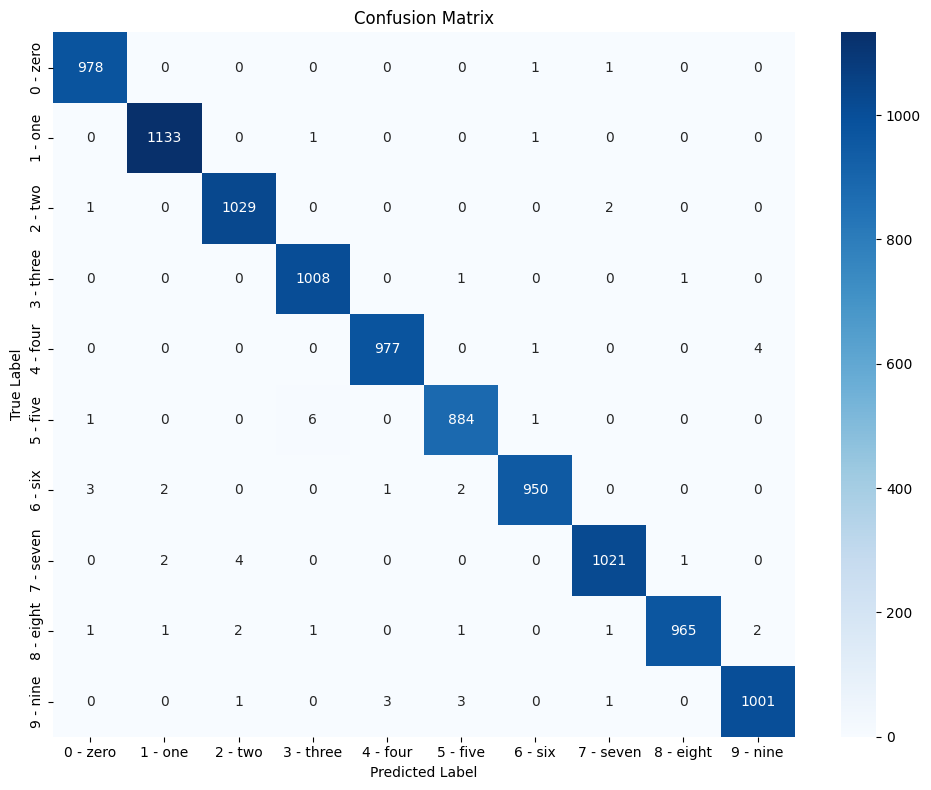

classification report:
               precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       0.99      1.00      1.00      1032
   3 - three       0.99      1.00      1.00      1010
    4 - four       1.00      0.99      1.00       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       1.00      0.99      0.99       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


오답 시각화:


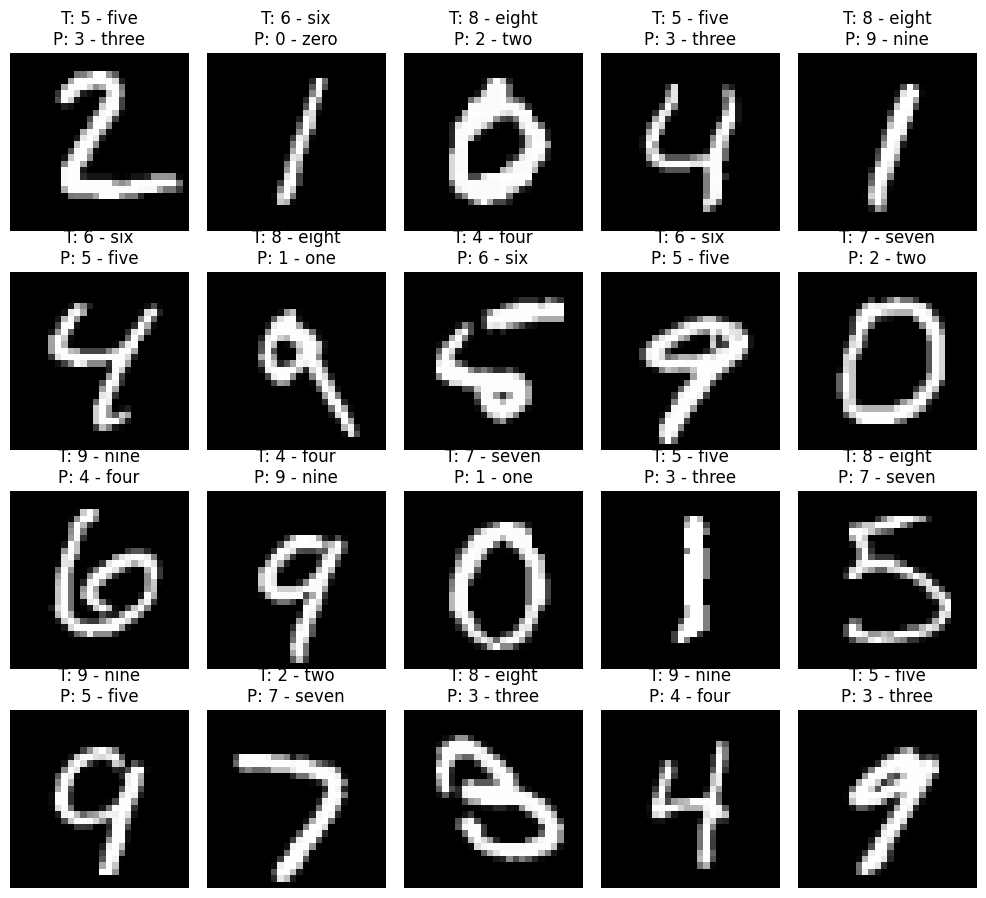

In [19]:
# 15) 모델 전체 테스트셋 추론 및 오답 시각화
model_all_test(dataloader=test_dataset_loader, model=model)

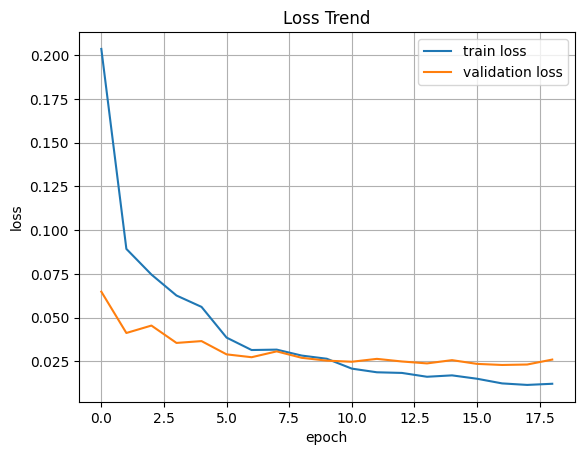

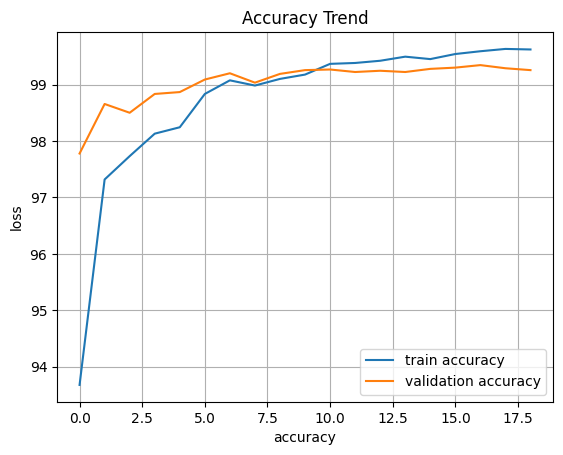

In [20]:
# 16) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [21]:
# 17) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_cnn_mnist.ckpt')

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


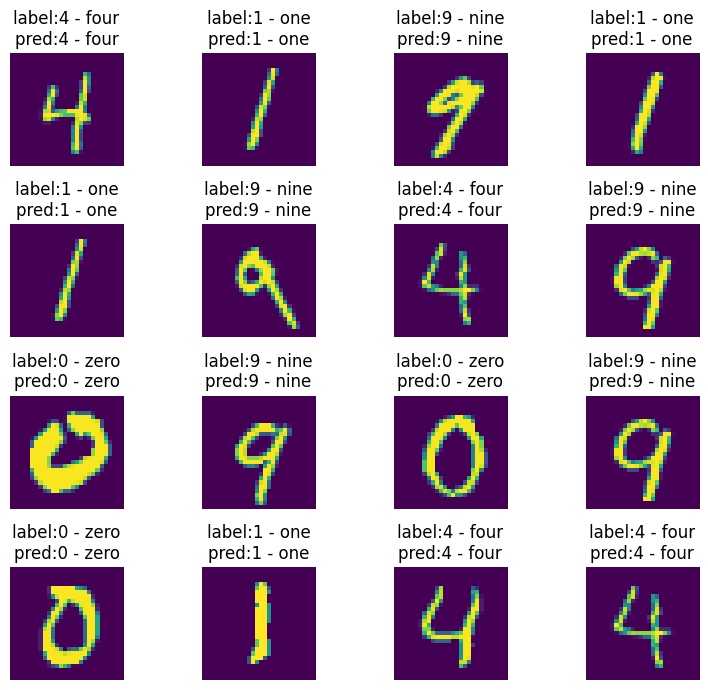

In [22]:
# 18) 단순 32개 샘플 테스트 - 모델 추론 및 예측값 추출
model = CNNModel().to(DEVICE)
model.load_state_dict(torch.load('./models/model_cnn_mnist.ckpt'))

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()